# *Monod* demonstration: identifying differenially regulated genes

We ran the *Monod* inference pipeline on eight pre-clustered mouse brain cell datasets, disaggregated into GABAergic and glutamatergic cell types. Each dataset was fit using the bursty model for transcriptional variation, coupled to a Poisson process for cDNA formation.

Given raw data, we can apply the $t$-test to spliced count data to identify genes that are differentially expressed (DE) between cell types. Further, we can iteratively it a Gaussian residual model to paired datasets' maximum likelihood physical parameter estimates. This allows us to ascribe changes in distribution shapes to the modulation of the rate of a particular biological process.

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import time
t1 = time.time()

In [2]:
from preprocess import *
from extract_data import extract_data
import cme_toolbox
from cme_toolbox import CMEModel
import inference
from inference import InferenceParameters, GradientInference
import analysis 
from analysis import *


In [3]:
dataset_meta = ['B08','C01','F08','H12']
cluster_names = ['gaba','glu']
dataset_names_gaba = ['allen_'+x+'_'+cluster_names[0] for x in dataset_meta] 
dataset_names_glu = ['allen_'+x+'_'+cluster_names[1] for x in dataset_meta] 
n_datasets = len(dataset_names_glu)

In [4]:
dir_string = './fits/gg_220602_022_allen_celltypes_1'

result_strings_gaba = [dir_string+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names_gaba]
result_strings_glu = [dir_string+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names_glu]

sd_strings_gaba = [dir_string+'/'+x+'/raw.sd' for x in dataset_names_gaba]
sd_strings_glu = [dir_string+'/'+x+'/raw.sd' for x in dataset_names_glu]

In [5]:
result_strings_glu

['./fits/gg_220602_022_allen_celltypes_1/allen_B08_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_220602_022_allen_celltypes_1/allen_C01_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_220602_022_allen_celltypes_1/allen_F08_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_220602_022_allen_celltypes_1/allen_H12_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res']

In [6]:
sr_arr_gaba = []
sr_arr_glu = []

sd_arr_gaba = []
sd_arr_glu = []

for j in range(n_datasets):
    sd = load_search_data(sd_strings_gaba[j])
    sr = load_search_results(result_strings_gaba[j])
    
    sd_arr_gaba.append(sd)
    sr_arr_gaba.append(sr)

    sd = load_search_data(sd_strings_glu[j])
    sr = load_search_results(result_strings_glu[j])
    
    sd_arr_glu.append(sd)
    sr_arr_glu.append(sr)


INFO:root:Search data loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_gaba/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_gaba/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_glu/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_C01_gaba/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_C01_gaba/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_C01_glu/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_C01_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220602_0

In [8]:
n_phys_pars = sr_arr_gaba[0].sp.n_phys_pars
n_genes = sr_arr_gaba[0].n_genes
pval_thr = 0.1/n_genes
param_names = sr_arr_gaba[0].model.get_log_name_str()
gn = sr_arr_gaba[0].gene_names

## Differential expression and regulation testing within a replicate

First, run the $t$-test.

INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/mean_comparison_s.png.


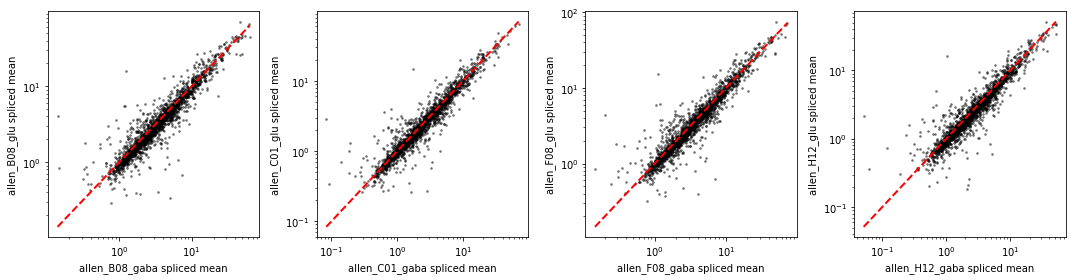

In [22]:
fig1,ax1= plt.subplots(1,n_datasets,figsize=(15,4))
for j in range(n_datasets):
    m1 = [sd_arr_gaba[j].moments[x]['S_mean']  for x in range(n_genes)]
    m2 = [sd_arr_glu[j].moments[x]['S_mean'] for x in range(n_genes)]
    ax1[j].scatter(m1,m2,3,'k',alpha=0.4)
    ax1[j].set_xscale('log')
    ax1[j].set_yscale('log')
    ax1[j].set_xlabel(dataset_names_gaba[j] +' spliced mean')
    ax1[j].set_ylabel(dataset_names_glu[j] +' spliced mean')
#     ax1[j].set_title('Spliced mean comparison')
    xl = [min(m1),max(m1)]
    ax1[j].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()
fig_string = sr_arr_gaba[0].batch_analysis_string+'/mean_comparison_s.png'
plt.savefig(fig_string,dpi=450)
log.info('Figure stored to {}.'.format(fig_string))


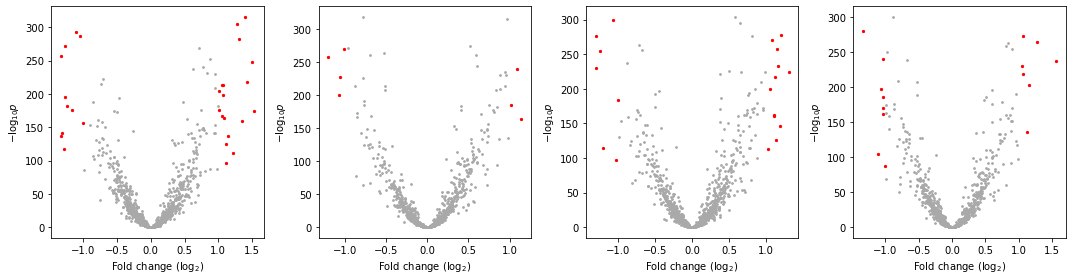

In [23]:
fig1,ax1= plt.subplots(1,n_datasets,figsize=(15,4))

de_ttest = np.zeros((n_datasets,n_genes),dtype=bool)

for j in range(n_datasets):
    gf_ttest,fc_ = compute_diffexp(sd_arr_gaba[j],sd_arr_glu[j],lognormalize=True,viz=True,method='ttest',
                                   ax1=ax1[j],pval_thr=pval_thr)
    de_ttest[j,:] = gf_ttest
fig1.tight_layout()

In [24]:
for j in range(n_datasets):
    print('Dataset: '+dataset_meta[j])
    print(gn[de_ttest[j,:]])
print('All:')
print(gn[de_ttest[:,:].all(0)])

Dataset: B08
['Abat' 'Ano3' 'Arap2' 'Arpp21' 'Cadps2' 'Camk2d' 'Cnih3' 'Diras2' 'Dkk3'
 'Dner' 'Dpp6' 'Foxp2' 'Gm17167' 'Grm1' 'Grm3' 'Igsf9b' 'Kcnip3' 'Limch1'
 'Lingo1' 'Luzp2' 'Nav1' 'Ngef' 'Pde1a' 'Phf24' 'Ppargc1a' 'Rab3c'
 'Rap1gap2' 'Rasgrp1' 'Rorb' 'Slc35f1' 'Snca' 'Srgap3' 'Stx1a' 'Sv2b'
 'Tafa5' 'Zbtb20']
Dataset: C01
['Cadps2' 'Camk2d' 'Cnih3' 'Diras2' 'Dkk3' 'Gm17167' 'Grm1' 'Nav1' 'Prkca'
 'Rorb' 'Satb1' 'Snca' 'Tafa5']
Dataset: F08
['Cadps2' 'Camk2d' 'Cnih3' 'Diras2' 'Dkk3' 'Dner' 'Foxp2' 'Gm17167' 'Grm1'
 'Grm3' 'Igsf9b' 'Kcnip3' 'Limch1' 'Nav1' 'Ncam2' 'Pde1a' 'Ppargc1a'
 'Rasgrp1' 'Rorb' 'Satb1' 'Slc35f1' 'Snca' 'Srgap3' 'Sv2b' 'Tafa5' 'Tle4'
 'Zbtb20']
Dataset: H12
['Arap2' 'Cadps2' 'Camk2d' 'Cnih3' 'Diras2' 'Dner' 'Gm17167' 'Gria3'
 'Grm1' 'Igsf9b' 'Nav1' 'Ncam2' 'Prkca' 'Rgs8' 'Rorb' 'Satb1' 'Snca'
 'Tafa5' 'Zbtb20']
All:
['Cadps2' 'Camk2d' 'Cnih3' 'Diras2' 'Gm17167' 'Grm1' 'Nav1' 'Rorb' 'Snca'
 'Tafa5']


Now, inspect parameter values.

INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/pair_parameter_comparison_B08.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/pair_parameter_comparison_C01.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/pair_parameter_comparison_F08.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/pair_parameter_comparison_H12.png.


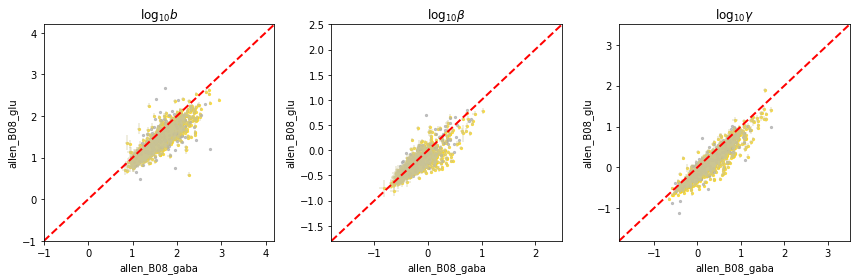

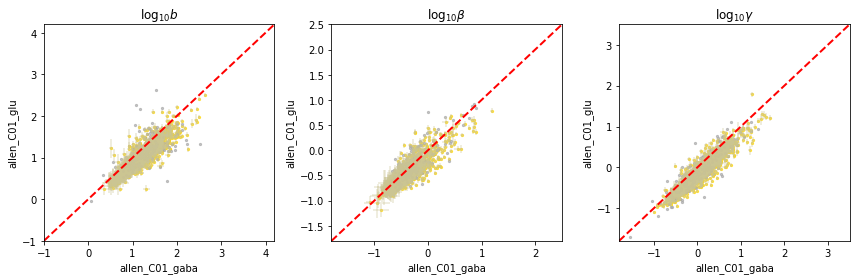

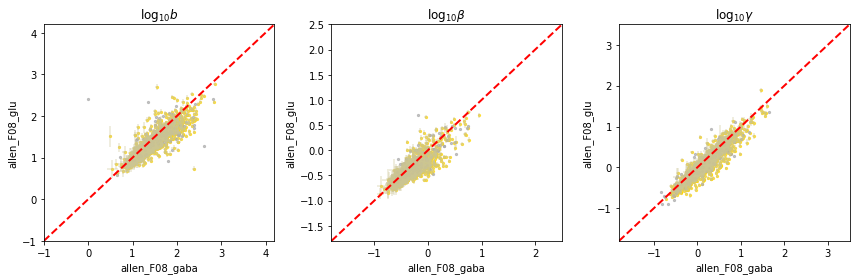

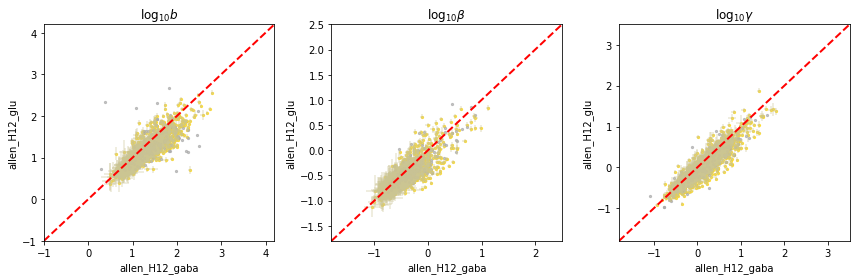

In [25]:
for j in range(n_datasets):
    plot_params_for_pair(sr_arr_gaba[j],sr_arr_glu[j],\
                         distinguish_rej=True,plot_errorbars=True,meta = dataset_meta[j],xlabel = dataset_names_gaba[j],\
                         ylabel = dataset_names_glu[j])

Perform differential regulation analysis.

INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/parameter_residuals_B08.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/parameter_residuals_C01.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/parameter_residuals_F08.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/parameter_residuals_H12.png.


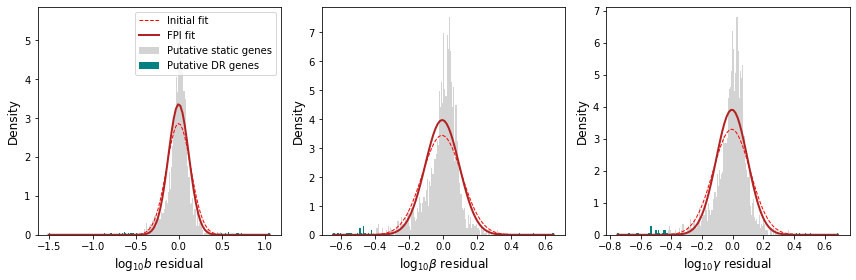

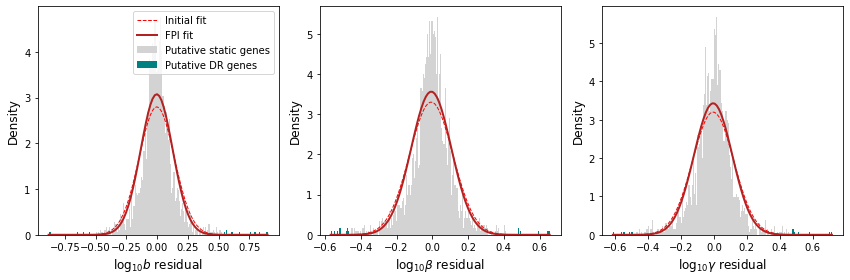

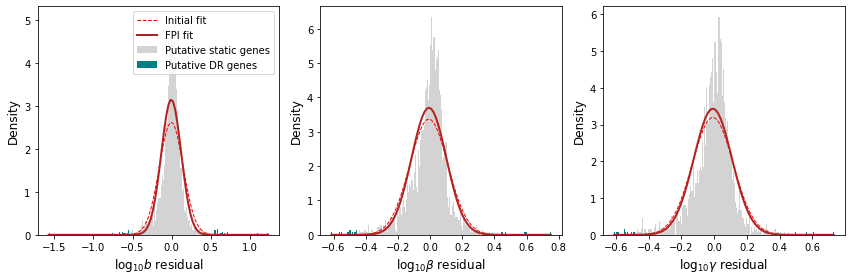

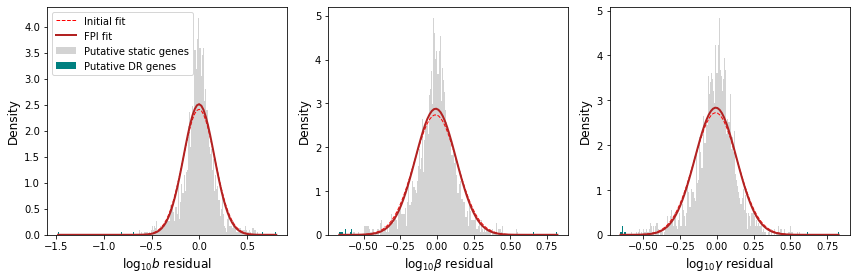

In [13]:
dr_analysis = []
for j in range(n_datasets):
    dr_analysis.append(compute_diffreg(sr_arr_gaba[j],sr_arr_glu[j],viz=True,modeltype='id',
                                       meta=dataset_meta[j],use_sigma=True,pval_thr=pval_thr))

In [49]:
dr_params.shape

(4, 3, 2130)

In [30]:
len(dr_analysis)

4

In [88]:
dr_par = np.swapaxes(np.asarray([x[1] for x in dr_analysis]),1,2)
fc_par = np.swapaxes(np.asarray([x[3]/np.log10(2) for x in dr_analysis]),1,2)

In [89]:
dr_par.shape

(4, 2130, 3)

Out of the 2130 genes under investigation, a handful are identified as DR under the Bonferroni correction.

In [90]:
dr_par.sum(1)

array([[21, 26, 33],
       [14, 15, 13],
       [28, 18, 14],
       [ 5, 10,  8]])

In [91]:
dr_par.shape

(4, 2130, 3)

In [92]:
param_names

('$\\log_{10} b$', '$\\log_{10} \\beta$', '$\\log_{10} \\gamma$')

Which ones? 

In [57]:
param_names_text = ('log10 b','log10 beta','log10 gamma')
for j in range(n_datasets):
    print('Dataset: '+dataset_meta[j])
    for k in range(n_phys_pars):
        print('Parameter: '+param_names_text[k])
        print(gn[dr_par[j,:,k]])
print('All:')
for k in range(n_phys_pars):
    print('Parameter: '+param_names_text[k])
    print(gn[dr_par[:,:,k].all(0)])

Dataset: B08
Parameter: log10 b
['2010300C02Rik' 'Cacna2d1' 'Dner' 'Egln1' 'Elavl2' 'Garnl3' 'Hnrnpll'
 'Kcnh3' 'Lzts1' 'Mtss1' 'Ncald' 'Ndst1' 'Pamr1' 'Ptk2b' 'Rell1' 'Satb2'
 'Sdk2' 'Sv2c' 'Tle4' 'Tspan14' 'Zbtb20']
Parameter: log10 beta
['2010300C02Rik' 'A230006K03Rik' 'Adgrl2' 'Ano3' 'Arpp21' 'Baiap2'
 'Cacna2d1' 'Cobl' 'Dlg1' 'Dscam' 'Elavl2' 'Kcnh3' 'Lzts1' 'Mast3' 'Nav1'
 'Pcsk2' 'Ptk2b' 'Rap1gap2' 'Rasgrp1' 'Satb1' 'Satb2' 'Srgap3' 'Sv2b'
 'Tox' 'Tspan14' 'Zbtb20']
Parameter: log10 gamma
['2010300C02Rik' 'A230006K03Rik' 'Adgrl2' 'Ano3' 'Baiap2' 'Cacna2d1'
 'Camk2a' 'Cobl' 'Dlg1' 'Dscam' 'Elavl2' 'Fam81a' 'Grm3' 'Kcnh3' 'Kcnk2'
 'Lingo1' 'Lzts1' 'Nav1' 'Neto2' 'Ngef' 'Pcsk2' 'Psd3' 'Ptk2b' 'Rap1gap2'
 'Rasgrp1' 'Rassf8' 'Satb1' 'Satb2' 'Srgap3' 'Sv2b' 'Tox' 'Tspan14'
 'Zbtb20']
Dataset: C01
Parameter: log10 b
['Diras2' 'Egln1' 'Extl3' 'Garnl3' 'Hnrnpll' 'Kcnh3' 'Mtss1' 'Ndst1'
 'Nfia' 'Pamr1' 'Rab3c' 'Rell1' 'Sdk2' 'Zbtb20']
Parameter: log10 beta
['A230006K03Rik' 'Ano3' 'Arpp21'

In [63]:
fc_par

array([[[ 0.05352043,  0.34509606,  0.29795496],
        [ 0.01867785, -0.07713564,  0.1602161 ],
        [-1.82990479, -1.56592151, -1.66186011],
        ...,
        [-0.03349559,  0.26944769,  0.1276439 ],
        [ 0.25349692,  0.35815287,  0.08004733],
        [ 0.12630086,  0.15221298,  0.1632506 ]],

       [[-0.10806942,  0.19782531,  0.21640363],
        [ 0.01982464, -0.15476979,  0.11759963],
        [-1.30394514, -0.93682831, -0.87464348],
        ...,
        [ 0.07969457,  0.42792548,  0.12973651],
        [ 0.30716411,  0.34655063,  0.12150528],
        [-0.19286324, -0.17694842, -0.16706933]],

       [[-0.00211964,  0.29943109,  0.36484489],
        [ 0.20734569,  0.05901427,  0.21617427],
        [-1.86408098, -1.44184775, -1.482015  ],
        ...,
        [ 0.1124721 ,  0.42732174,  0.1613748 ],
        [ 0.08854434,  0.10989378, -0.08658508],
        [ 0.31046185,  0.3080532 ,  0.32065693]],

       [[-0.01215656,  0.38132534,  0.3042203 ],
        [ 0.04041442, -0

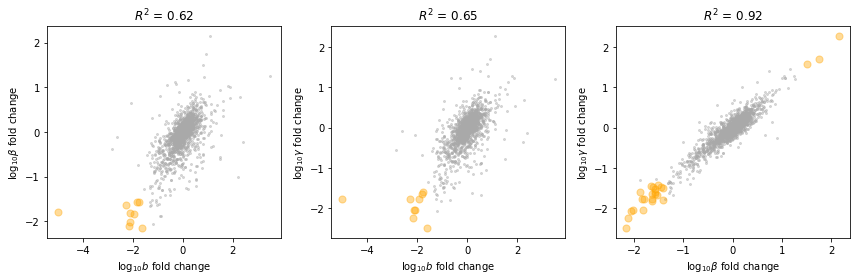

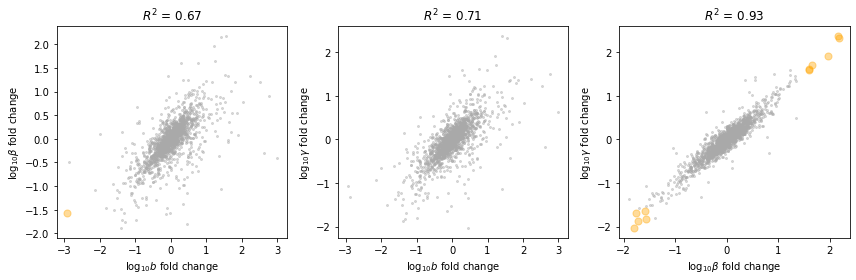

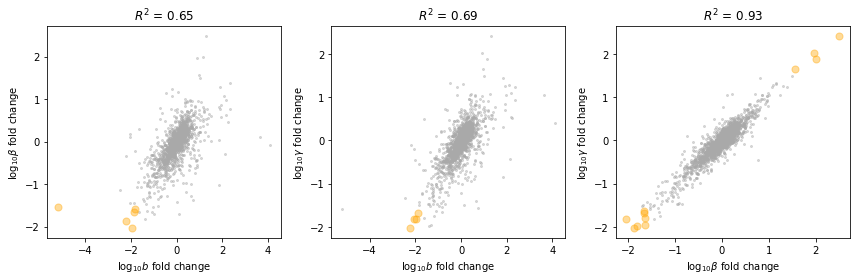

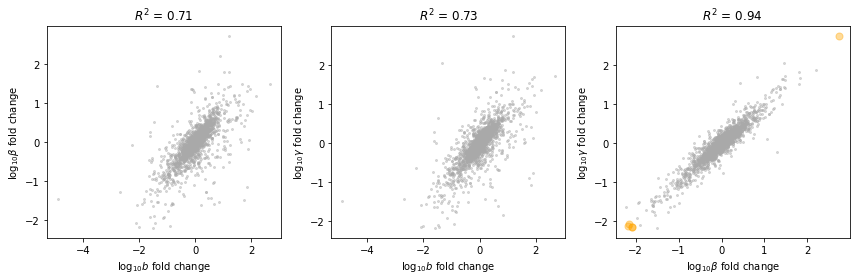

In [64]:
pairs = [[0,1],[0,2],[1,2]]
q=0
for j in range(n_datasets):
    fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
    q=0
    for pair in pairs:
        k1 = pair[0]
        k2 = pair[1]
        gf = dr_par[j,:,k1] & dr_par[j,:,k2]

        x = fc_par[j,:,k1]
        y = fc_par[j,:,k2]
        x[np.isnan(x)] = 0 
        y[np.isnan(y)] = 0

        ax1[q].scatter(x[~gf],y[~gf],4,'darkgray',alpha=0.4)
        ax1[q].scatter(x[gf],y[gf],50,'orange',alpha=0.4)
        ax1[q].set_xlabel(param_names[k1]+' fold change')
        ax1[q].set_ylabel(param_names[k2]+' fold change')
        xl = [x.min(),y.max()]
        cc = np.corrcoef(x,y)[0,1]
        ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
        q+=1
    fig1.tight_layout()

## Differential expression testing with biological replicates

Pull out log2 mean values for DE.

In [65]:
par_vals_uncorrected = np.zeros((2,n_datasets,n_genes,n_phys_pars))
mean_vals = np.zeros((2,n_datasets,n_genes))
sigma_vals = np.zeros((2,n_datasets,n_genes,n_phys_pars))
for j in range(n_datasets):
    par_vals_uncorrected[0,j,:,:] = sr_arr_gaba[j].phys_optimum
    par_vals_uncorrected[1,j,:,:] = sr_arr_glu[j].phys_optimum
    mean_vals[0,j,:] = np.log2([x['S_mean'] for x in sd_arr_gaba[j].moments])
    mean_vals[1,j,:] = np.log2([x['S_mean'] for x in sd_arr_glu[j].moments])
    sigma_vals[0,j,:,:] = sr_arr_gaba[j].sigma
    sigma_vals[1,j,:,:] = sr_arr_glu[j].sigma


Text(0, 0.5, 'Glu $\\log_2$ mean')

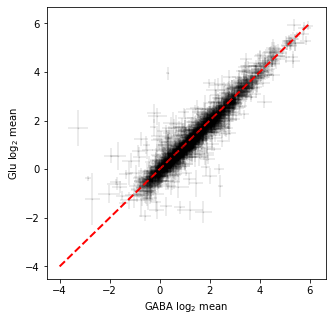

In [66]:
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))
ax1.errorbar(mean_vals[0,:,:].mean(0),mean_vals[1,:,:].mean(0),
                 mean_vals[0,:,:].std(0),mean_vals[1,:,:].std(0),'k.',alpha=0.1,markersize=1)

xl = [-4,6]
plt.plot(xl,xl,'r--',linewidth=2)
plt.xlabel('GABA $\log_2$ mean')
plt.ylabel('Glu $\log_2$ mean')

In [67]:
p_mean = np.zeros(n_genes)
for i in range(n_genes):
    p_mean[i] = scipy.stats.ttest_ind(mean_vals[0,:,i],mean_vals[1,:,i],equal_var=False)[1]

Text(0.5, 0, '$\\mu$ fold change across 4 datasets')

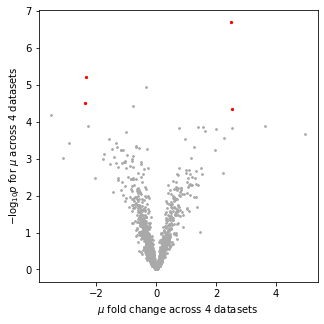

In [68]:
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))

fc_mean = (mean_vals[1,:,:]-mean_vals[0,:,:]).mean(0)
gf_pval = p_mean<pval_thr

gf_fc = np.abs(fc_mean)>1

gf = gf_pval & gf_fc

logp_mean = -np.log10(p_mean)
ax1.scatter(fc_mean[gf],logp_mean[gf],color='r',s=5)
ax1.scatter(fc_mean[~gf],logp_mean[~gf],color='darkgray',s=3)
ax1.set_ylabel(r'$-\log_{10} p$ for $\mu$ across 4 datasets')
ax1.set_xlabel(r'$\mu$ fold change across 4 datasets')


In [69]:
print(gn[gf])

['Dner' 'Pamr1' 'Rell1' 'Sv2c']


## Differential regulation testing with biological replicates

Inspect the fit parameter values. We observe offsets and hypothesize these are due to imprecision in the sampling parameter fits.

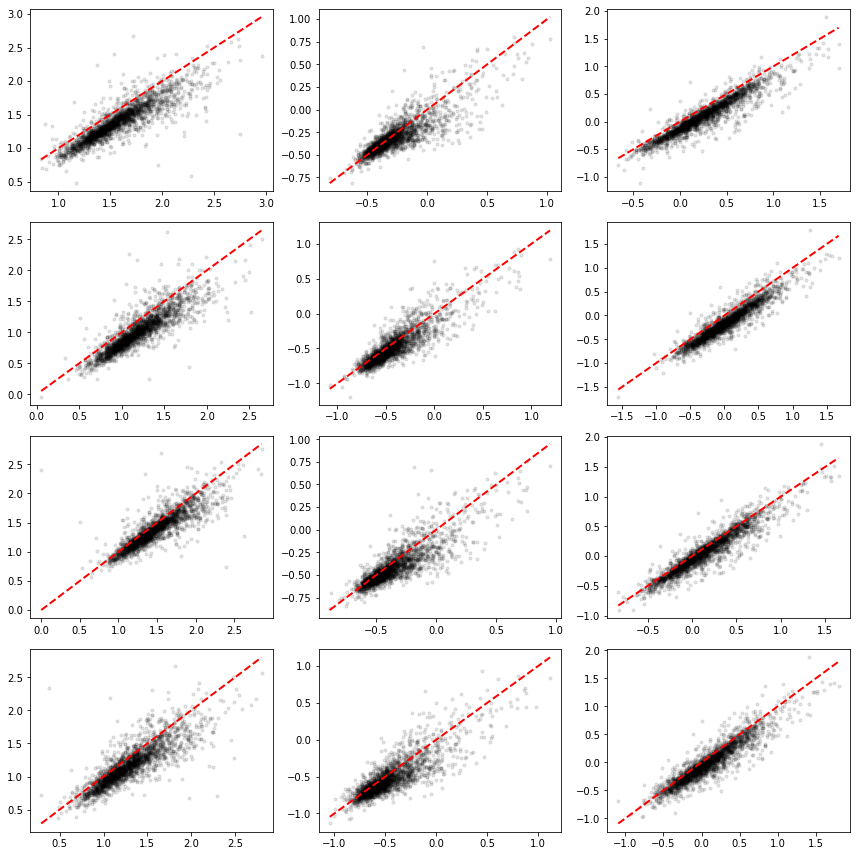

In [83]:
fig1,ax1 = plt.subplots(n_datasets,n_phys_pars,figsize=(12,12))
for d in range(n_datasets):
    for k in range(n_phys_pars):
        x=par_vals_uncorrected[0,d,:,k]
        y=par_vals_uncorrected[1,d,:,k]
        xl = [min(x),max(x)]
        ax1[d,k].scatter(x,y,10,'k',alpha=0.1) 

        ax1[d,k].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

In [84]:
offsets = []
par_vals = np.copy(par_vals_uncorrected)
for k in range(n_phys_pars):
    m1 = par_vals_uncorrected[0,0,:,k]
    for j in range(1,n_datasets):
        m2 = par_vals_uncorrected[0,j,:,k]
        offset = diffreg_fpi(m1,m2,param_names[k],viz=False)[1]
        par_vals[0,j,:,k] -= offset
    for j in range(n_datasets):
        m2 = par_vals_uncorrected[1,j,:,k]
        offset = diffreg_fpi(m1,m2,param_names[k],viz=False)[1]
        par_vals[1,j,:,k] -= offset
    
    

Inspect the fit parameter values after correction.

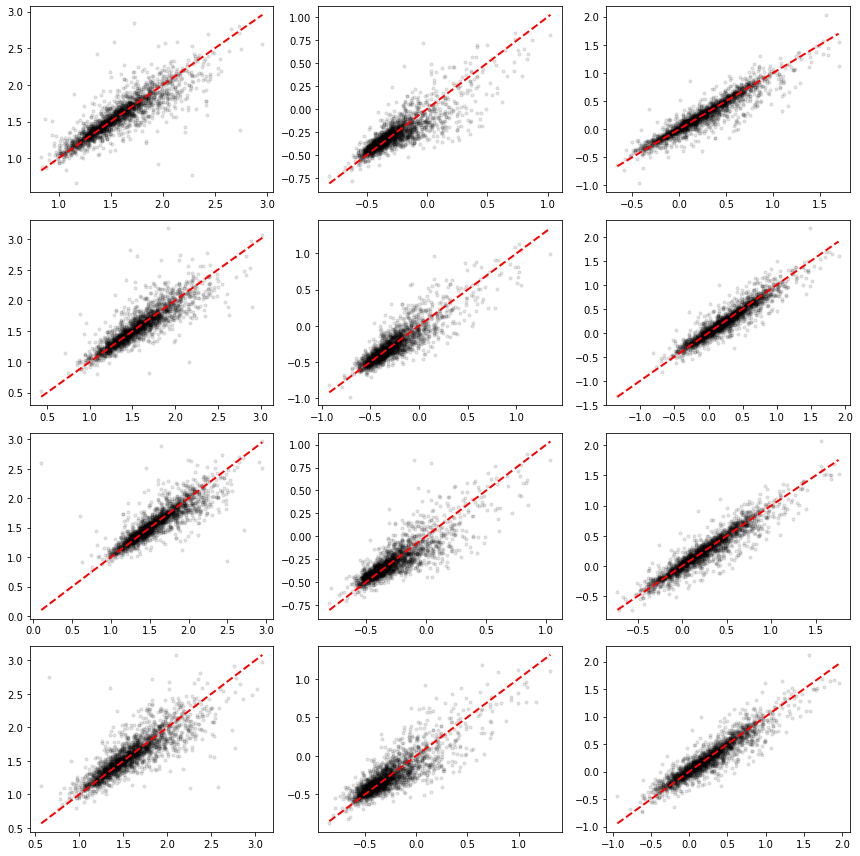

In [85]:
fig1,ax1 = plt.subplots(n_datasets,n_phys_pars,figsize=(12,12))
for d in range(n_datasets):
    for k in range(n_phys_pars):
        x=par_vals[0,d,:,k]
        y=par_vals[1,d,:,k]
        xl = [min(x),max(x)]
        ax1[d,k].scatter(x,y,10,'k',alpha=0.1) 

        ax1[d,k].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

Plot average and standard deviation across four datasets.

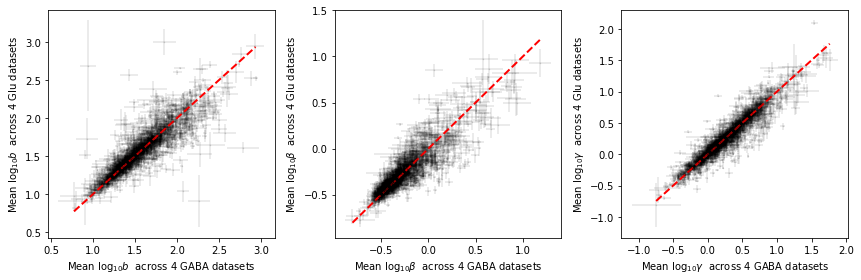

In [86]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
p =  []
for k in range(n_phys_pars):
    x=par_vals[0,:,:,k].mean(0)
    y=par_vals[1,:,:,k].mean(0)
    xl = [min(x),max(x)]
    ax1[k].errorbar(x,y,
                     par_vals[0,:,:,k].std(0),par_vals[1,:,:,k].std(0),'k.',alpha=0.1,markersize=1) 
    
    ax1[k].plot(xl,xl,'r--',linewidth=2)
    ax1[k].set_xlabel(r'Mean '+param_names[k]+'  across 4 GABA datasets')
    ax1[k].set_ylabel(r'Mean '+param_names[k]+'  across 4 Glu datasets')
fig1.tight_layout()

In [87]:
p_par = np.zeros((n_genes,n_phys_pars))
for k in range(n_phys_pars):
    for j in range(n_genes):
        p_par[j,k] = scipy.stats.ttest_ind(par_vals[0,:,j,k],par_vals[1,:,j,k],equal_var=False)[1]
    

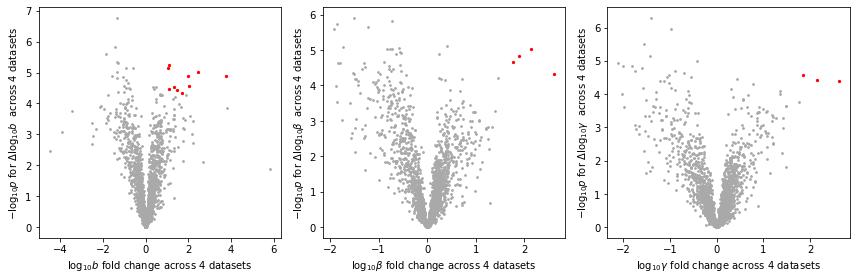

In [76]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
fc_par_multi = ((par_vals[1,:,:,:]-par_vals[0,:,:,:])/np.log10(2)).mean(0)
dr_par_multi = np.zeros((n_genes,n_phys_pars),dtype=bool)
for k in range(n_phys_pars):
    fc_d = fc_par_multi[:,k]
    gf_pval = p_par[:,k]<pval_thr
    
    gf_fc = fc_d>1
    gf = gf_pval & gf_fc
    
    dr_par_multi[:,k] = gf
    
    logp_par = -np.log10(p_par[:,k])
    ax1[k].scatter(fc_d[gf],logp_par[gf],color='r',s=5)
    ax1[k].scatter(fc_d[~gf],logp_par[~gf],color='darkgray',s=3)
    ax1[k].set_ylabel(r'$-\log_{10} p$ for $\Delta$'+param_names[k]+'  across 4 datasets')
    ax1[k].set_xlabel(param_names[k]+' fold change across 4 datasets')
fig1.tight_layout()

In [77]:
for k in range(n_phys_pars):
    print(gn[dr_par_multi[:,k]])

['Extl3' 'Garnl3' 'Lpgat1' 'Ndst1' 'Nhsl2' 'Prkce' 'Sdk2' 'Sec62' 'Srgap3'
 'Tle4']
['A230006K03Rik' 'Camk2d' 'Nav1' 'Srgap3']
['A230006K03Rik' 'Camk2d' 'Nav1']


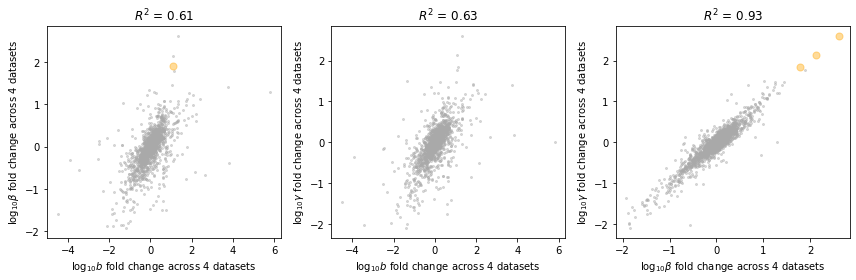

In [78]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[0,1],[0,2],[1,2]]
q=0
for pair in pairs:
    k1 = pair[0]
    k2 = pair[1]
    gf = dr_par_multi[:,k1] & dr_par_multi[:,k2]
    
    x = fc_parval[:,k1]
    y = fc_parval[:,k2]
    
    ax1[q].scatter(x[~gf],y[~gf],4,'darkgray',alpha=0.4)
    ax1[q].scatter(x[gf],y[gf],50,'orange',alpha=0.4)
    ax1[q].set_xlabel(param_names[k1]+' fold change across 4 datasets')
    ax1[q].set_ylabel(param_names[k2]+' fold change across 4 datasets')
    xl = [fc_parval[:,1].min(),fc_parval[:,1].max()]
    cc = np.corrcoef(x,y)[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    q+=1
fig1.tight_layout()

## Validation comparisons

In [79]:
dr_params.shape

(4, 2130, 3)

In [80]:
gf_par.shape

(2130, 3)

In [98]:
gf_par.sum(1)

array([10,  4,  3])

In [82]:
gf = (dr_params.any(0) & gf_par).sum(0)

array([5, 4, 3])

We correctly identify the 